beim Abschlussprojekt bin ich gerade dabei Daten zu Feinstaubkonzentrationen in Stuttgart bzw. in deutschen Großstädten in einem Dashboard interaktiv zu visualisieren. Es werden voraussichtlich Sentinel Daten und/oder in-situ Daten sein (https://aqicn.org/city/germany/badenwurttemberg/stuttgart-arnulf-klett-platz/de, https://meeo-s5p.s3.amazonaws.com/index.html?t=catalogs#/?t=catalogs).


Als 3 "best-practice methods" habe ich vor, folgende Methoden zu nutzen:

- Error handling: ein paar Tests schreiben (zB. korrektes Einlesen der Daten..) und Debugger nutzen  (+ evtl. off-the-self unit testing library)
- DRY Principle: Module schreiben und open source code nutzen
- Github nutzen

In [304]:
import os
import math
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
import rasterio.plot
import pyproj
from satsearch import Search
import matplotlib.pyplot as plt
%matplotlib inline

### Luftdaten API

In [646]:
import glob

In [1183]:
def mergedCSVpattern(pattern_list, selected_cols=None, sep_char="[;,|]"):
    '''
    pattern_list: list of identical patterns in filenames to merge files with same pattern 
    selected_cols : predefine which columns should be loaded
    sep_char : string or regular expression to indicate seperator
    return : group files in current and all subdirectories based on pattern in filename and filetype to one pd.DF
    '''
    df_combi_list= []
    
    for item in pattern_list:
        ## also look in the next subfolder
        files = glob.glob("**/*{}*.csv".format(item), recursive=True) ## get from cur. dir and all sub.dirs
        df_combi = pd.concat([pd.DataFrame(pd.read_csv(f, sep=sep_char, engine="python"), columns=selected_cols) for f in files], join="inner")# join on identical col.names
        # try to fetch multiple separor types, def engine="python" to not confuse it with regex separators, which cn be read via c-engine 
        df_combi_list.append(df_combi)
   
    return df_combi_list

In [1192]:
os.chdir(r"C:\Users\Anna\Documents\UNI\MA Semi 1\Adv Geoscripting\AdvGeo_Project\data\archive.sensor.community")
pattern_list = [13083, 10963, 33882,2700]
sel_cols = ["sensor_id","timestamp","lon","lat", "P1", "P2"]

## own func from above
df_combi_list = mergedCSVpattern(pattern_list,sel_cols, sep_char=";")


df_combi_list[2]

,sensor_id,timestamp,lon,lat,P1,P2
0,33882,2020-11-01T00:03:53,9.196731,48.789461,24.43,10.67
1,33882,2020-11-01T00:08:54,9.196731,48.789461,18.63,9.88
2,33882,2020-11-01T00:13:54,9.196731,48.789461,25.37,11.00
3,33882,2020-11-01T00:18:56,9.196731,48.789461,17.60,9.60
4,33882,2020-11-01T00:23:57,9.196731,48.789461,18.60,10.55
...,...,...,...,...,...,...
240,33882,2020-11-04T23:19:45,9.196731,48.789461,12.57,3.65
241,33882,2020-11-04T23:24:48,9.196731,48.789461,9.80,3.42
242,33882,2020-11-04T23:39:57,9.196731,48.789461,8.27,3.17
243,33882,2020-11-04T23:45:10,9.196731,48.789461,11.00,3.17


In [1193]:
from shapely.geometry import Point
import datetime


#filepath = r"C:\Users\Anna\Documents\UNI\MA Semi 1\Adv Geoscripting\AdvGeo_Project\data\archive.sensor.community"
#luftdaten_list= [f for f in glob.glob(filepath+"**/*/*.csv", recursive=True)]

outpath = r"C:\Users\Anna\Documents\UNI\MA Semi 1\Adv Geoscripting\AdvGeo_Project\data"
data_list = list()

#df_list = [pd.DataFrame(, columns=[
#        "sensor_id","timestamp","lon","lat", "P1", "P2"]) for i in luftdaten_list]

for index, df in enumerate(df_combi_list):
    ## define datatype for columns
    df.astype({"sensor_id":"int",
                "timestamp":"datetime64",
               "lon":"float16",
               "lat":"float16",
               "P1":"float16",
               "P2":"float16"}).dtypes
    
    ## convert df to GeoDF
    df["geometry"] = df.apply(lambda x: Point(x["lon"], x["lat"]), axis=1) # axis 1 = x Achse
    data = gpd.GeoDataFrame(df, crs="EPSG:4326") # geodetic CRS

    ## check if NAs exist
    #data.isna().sum()

    ## convert time to appropiate format
    data["timestamp"]  = pd.to_datetime(data["timestamp"], format="%Y%m%d %H:%M:%S") 


    ## set time as df.index
    data.set_index("timestamp", inplace=True, drop=True)
    data.sort_index(inplace=True)

    ## round measurments to hourly values
    data = data.resample("H").mean() # OR sum()
#print(data.iloc[0:30])
    ## fill misisng index dates via pd.resample() with 0--> no 0 measurments in P1 and p2
    #data_complet = data.resample('H').sum().fillna(0)

#     ### create P1 category for each station
#     c = []
#     NO2_boundary = 70.0
#     for i in data["P1"].values:
#         if i < NO2_boundary:
#             c.append(0)
#         elif i >= NO2_boundary:
#             c.append(1)
# #    print(c)
# #    print(data["P1"])
#     data["P1_category"] = c
    
    data_list.append(data)
    
    
print(data_list[1])


# # data_complete = data                  


                     sensor_id   lon     lat        P1        P2
timestamp                                                       
2020-10-08 21:00:00    10963.0  9.19  48.784  2.774286  0.982857
2020-10-08 22:00:00    10963.0  9.19  48.784  3.622500  1.293750
2020-10-08 23:00:00    10963.0  9.19  48.784  3.002000  1.510000
2020-10-09 00:00:00    10963.0  9.19  48.784  4.065789  1.578421
2020-10-09 01:00:00    10963.0  9.19  48.784  4.180500  1.720000
...                        ...   ...     ...       ...       ...
2020-11-03 19:00:00    10963.0  9.19  48.784  8.238400  3.739600
2020-11-03 20:00:00    10963.0  9.19  48.784  7.576667  3.459583
2020-11-03 21:00:00    10963.0  9.19  48.784  7.130400  3.747200
2020-11-03 22:00:00    10963.0  9.19  48.784  5.106000  2.136800
2020-11-03 23:00:00    10963.0  9.19  48.784  5.544583  1.671250

[627 rows x 5 columns]


### Weather Data API
Use the Dark Sky service, which allows us to gather historical weather reports for any place in the world. The weather API is REST and JSON-based, so we'll use the urllib module to request data and the json library to parse it. Of note in this section is that we cache the data locally, so you can run the script offline for testing if need be. Early on in this section is where you place your Dark Sky API key that is flagged by the YOUR KEY HERE text. Let's have a look at the following steps:

source: https://learning.oreilly.com/library/view/learning-geospatial-analysis/9781789959277/79803c00-d1c6-4587-bb75-97ab68afaded.xhtml

In [1156]:
import pyowm
from pyowm.utils import timestamps, formatting

#import requests
import json
from datetime import datetime,date

In [1157]:
#api_key = "b2872e6e8ac214afbd9421ff1a3f5f61"
owm = OWM("b2872e6e8ac214afbd9421ff1a3f5f61")
mgr = owm.weather_manager()
#owm.configuration

In [1158]:
reg = owm.city_id_registry()
list_of_tuples = reg.ids_for('Stuttgart')    
# matching=like --> get suburbs
list_of_tuples = reg.ids_for('Stuttgart', country='DE', matching='like')          
id_of_city = list_of_tuples
id_of_city # 2825297 - amin Suttgart


[(3214105, 'Regierungsbezirk Stuttgart', 'DE'),
 (3220785, 'Stadtkreis Stuttgart', 'DE'),
 (2927043, 'Stuttgart Feuerbach', 'DE'),
 (2867993, 'Stuttgart Mühlhausen', 'DE'),
 (2825297, 'Stuttgart', 'DE'),
 (6930414, 'Stuttgart-Ost', 'DE')]

In [1159]:
lat = 48.79
lon = 9.19

In [1160]:
from datetime import datetime, timedelta, date, time

all_weatherdays = []
d = {}
weather_df =pd.DataFrame([])

today = datetime.today() #datetime.utcnow() 

for d in range(1,5,1):
    prevDay = today - timedelta(days=d) 
    unix_t = int(datetime.timestamp(prevDay))
    #Day_var ="prevDay_" +str(Day) 

    url = "https://api.openweathermap.org/data/2.5/onecall/timemachine?lat=%s&lon=%s&dt=%s&exclude=minutely,alerts&appid=%s&units=metric" % (lat, lon, unix_t, api_key) 
    response = requests.get(url)
    weatherdata = json.loads(response.text)
    #print(data)

    singelDate = weatherdata["hourly"]
    
    prev_Dates = {}
    
    hourly = 0
    for hourly in range(len(singelDate)):
        prev_Dates["dt"] = datetime.fromtimestamp(singelDate[hourly]["dt"]).strftime("%Y-%m-%d %H:%M:%S")#.isoformat()
        
        prev_Dates["temp"] = singelDate[hourly]["temp"]
        prev_Dates["pressure"] = singelDate[hourly]["pressure"]
        prev_Dates["humid"] = singelDate[hourly]["humidity"]
        prev_Dates["wind_speed"] = singelDate[hourly]["wind_speed"]
        prev_Dates["wind_deg"] = singelDate[hourly]["wind_deg"]
        
        all_weatherdays.append(prev_Dates.copy())

        hourly += 1

       
all_weatherdays = pd.DataFrame(all_weatherdays)
all_weatherdays["timestamp"]  = pd.to_datetime(all_weatherdays["dt"], format="%Y%m%d %H:%M:%S") 
## set time as df.index
all_weatherdays.set_index('timestamp', inplace=True, drop=True)
all_weatherdays.sort_index(inplace=True)
all_weatherdays= all_weatherdays.drop(["dt"],axis = 1)



In [1161]:
## merge weatherdata with station dfs
#data_list
df_all_list = []


for index, df in enumerate(data_list):
    df_all = pd.merge(df, all_weatherdays, on="timestamp" )
    
    ## remove all rows where P1 or P2 = NA
    df_all.dropna(subset = ["P1","P2"], inplace=True)
    #print(df_all.isna().sum())
    
    ## avoid problems with bites --> round all floats
    df_all = df_all.round(2)
    df_all_list.append(df_all)
    ## save
    filepath = os.path.join(outpath, "dataset_"+str(df_all["sensor_id"].values[0])+".csv")
    df_all.to_csv(filepath, sep=";")
    
    
df_all_list[0]

,sensor_id,lon,lat,P1,P2,temp,pressure,humid,wind_speed,wind_deg
timestamp,,,,,,,,,,
2020-11-01 01:00:00,13083,9.2,48.79,183.68,67.47,8.05,1021,87,1.0,0
2020-11-01 02:00:00,13083,9.2,48.79,187.75,67.45,8.63,1020,87,1.0,0
2020-11-01 03:00:00,13083,9.2,48.79,188.85,67.62,9.84,1019,76,0.5,0
2020-11-01 04:00:00,13083,9.2,48.79,189.31,67.48,10.16,1019,81,1.0,0
2020-11-01 05:00:00,13083,9.2,48.79,190.59,68.36,10.78,1020,93,1.0,0
...,...,...,...,...,...,...,...,...,...,...
2020-11-03 19:00:00,13083,9.2,48.79,181.28,63.87,9.05,1026,93,1.0,0
2020-11-03 20:00:00,13083,9.2,48.79,179.03,63.41,9.11,1026,93,1.0,0
2020-11-03 21:00:00,13083,9.2,48.79,177.97,63.99,9.09,1027,93,2.1,240


In [1162]:
# #Now we're ready to do our weather data query as follows:
# #data = mgr.one_call_history(lat=lat, lon=lon, dt=unix_t)
# #data.current                                                                                                                                      
# #######################
# url = "https://api.openweathermap.org/data/2.5/onecall/timemachine?lat=%s&lon=%s&dt=%s&exclude=minutely,alerts&appid=%s&units=metric" % (lat, lon, unix_t, api_key) 
# response = requests.get(url)
# data = json.loads(response.text)
# print(data)
# ################ dark sky example
# #history_req =https://api.darksky.net/forecast/{}/".format(api_key)
# # #name_info = [t.tm_year, t.tm_mon, t.tm_mday, route_url.split(".")[0]]
# # #history_req += "/history_{0}{1:02d}{2:02d}/q/{3}.json" .format(*name_info)
# # history_req += "{},{},{}".format(centy, centx, t)
# # history_req += "?exclude=currently,minutely,hourly,alerts,flags"
# # request = urllib.request.urlopen(history_req)
# # weather_data = request.read()

In [1163]:
# # #current Data point dt refers to the requested time, rather than the current time
# # # current.temp vs current.dt

In [1164]:
# import pytz
# imprt pyown # pytho
# # ##Hourly Forecast
# # #The hourly forecast is stored under the key hourly – it is easy to iterate over the result set and extract the hour and temperature for each entry:
# # # hourly Data block contains hourly historical data starting at 00:00 on the requested day and continues until 23:59 on the same day (UTC time)
        
# # from datetime import datetime

# # hourly = data["hourly"]
# # for entry in hourly:
# #     dt = datetime.fromtimestamp(entry["dt"], pytz.timezone('Europe/Berlin'))
# #     temp = entry["temp"]
# # temp

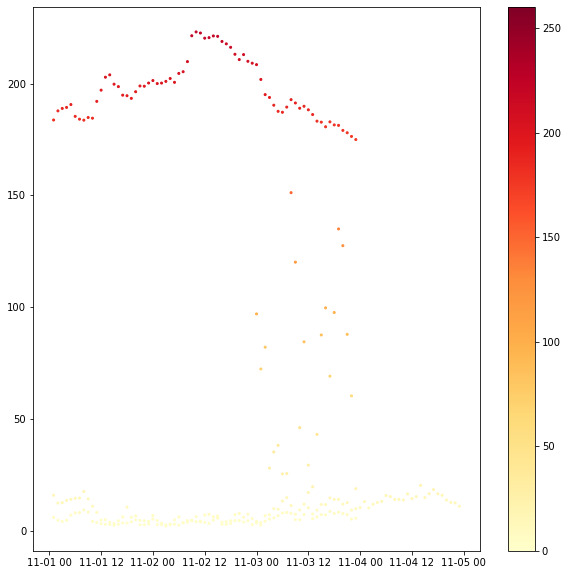

In [1165]:
## Visualize PM concentration as timeseries
#fig = plt.figure(figsize=(30,7))
#cm = plt.cm.get_cmap('YlOrRd')
#sc = plt.scatter(x=df_all_list[0].index, y=df_all_list[0]['P1'], vmin=0, vmax=160, c=df_all_list[0]['P1'] ,s=4, cmap=cm)
    
#ax = df_all_list[0].plot()

#ax = df_all_list[0].plot(kind="scatter", x=df_all_list[0].index, y=df_all_list[0]["P1"], color=df_all_list[0]["P1"])#, s=4, cmap=cm)
#for f in df_all_list:
    #f.plot(x=f[0].index, y=f[0]["P1"], color=df_all_list[0]["P1"], ax=ax)
#    ax.scatter(x=f.index, y=f['P1'], vmin=0, vmax=160, c=f['P1'] ,s=4, cmap=cm)
    
    #df.plot( x="x",y="c", color="g", label="c vs. x", ax=ax)
#df.plot( x="d",y="x", color="orange", label="b vs. d", ax=ax)
#df.plot( x="a",y="x", color="purple", label="x vs. a", ax=ax)

# ax.set_xlabel("horizontal label")
# ax.set_ylabel("vertical label")
# plt.show()

# fig, ax = plt.subplots()
# for f in df_all_list:
#     df_all_list[f].plot(ax=ax)

sc = plt.scatter(x=df_all_list[0].index, y=df_all_list[0]['P1'], vmin=0, vmax=260, c=df_all_list[0]['P1'] ,s=4, cmap=cm)
plt.scatter(x=df_all_list[1].index, y=df_all_list[1]['P1'], vmin=0, vmax=260, c=df_all_list[1]['P1'] ,s=4, cmap=cm)
plt.scatter(x=df_all_list[2].index, y=df_all_list[2]['P1'], vmin=0, vmax=260, c=df_all_list[2]['P1'] ,s=4, cmap=cm)
plt.scatter(x=df_all_list[3].index, y=df_all_list[3]['P1'], vmin=0, vmax=260, c=df_all_list[3]['P1'] ,s=4, cmap=cm)
#plt.scatter(x=df_all_list[4].index, y=df_all_list[4]['P1'], vmin=0, vmax=260, c=df_all_list[4]['P1'] ,s=4, cmap=cm)
    
plt.colorbar(sc)

plt.show()


In [1166]:
## Alternative Plot 
# import seaborn as sns

#df[['no2', 'state']].groupby(['state']).median().sort_values("no2", ascending = False).plot.bar(figsize=(20,10))


# df = data_complete['P1'].reset_index().sort_values(by='timestamp',ascending=False) #groupby(data_complete.index).median().reset_index()
# f,ax=plt.subplots(figsize=(15,10))
# sns.pointplot(x='timestamp', y='P1', data=df)

In [1167]:
# ### Boxplot: see destribution of P1 and P2 , are there outliers??
# sns.boxplot(y=data_complete['P1'], color="red")
# #sns.boxplot(y=data_complete['P2'])



In [1168]:
# ## HEatmap or timeseries

## PIVOT Table: plot NO2/SPM concetration for each station:   years ~ station position
# fig, ax = plt.subplots(figsize=(20,10))      
# sns.heatmap(df.pivot_table('so2', index='state',columns=['year'],aggfunc='median',margins=True),ax = ax,annot=True, linewidths=.5)

# ## trends per station/city
# temp = df.pivot_table('so2', index='year',columns=['state'],aggfunc='median',margins=True).reset_index()
# temp = temp.drop("All", axis = 1)
# temp = temp.set_index("year")
# temp.plot(figsize=(20,10))


In [1194]:
## prepare df_list to single dff orderd by timestamp and sensor_id
## prepare combined csv files for SVC by merging them based on timestamp and sensor to one DF
os.chdir(r"C:\Users\Anna\Documents\UNI\MA Semi 1\Adv Geoscripting\AdvGeo_Project\data")
patternlist = ["dataset"]
#sel_cols = []
         
## own func from above
#infile_list = pd.read_csv("dataset_13083.csv", sep=";", engine="python") 
inf_svc_list = mergedCSVpattern(patternlist)

svc_df = pd.DataFrame(inf_svc_list[0])#.reset_index() # get only df in list
#infile_df.astype({"timestamp":"datetime", "sensor_id":"int", "lon":"float16", "lat":"float16", "P1":"float16", "P2":"float16"}).dtypes
    #print(infile_df)

svc_df = svc_df.sort_values(by=["timestamp", "sensor_id"])

## set index
svc_df.set_index('timestamp', inplace=True, drop=True)
svc_df.sort_index(inplace=True)
#svc_df= all_weatherdays.drop(["dt"],axis = 1)
print(svc_df)


                     sensor_id   lon    lat      P1     P2  temp  pressure  \
timestamp                                                                    
2020-11-01 01:00:00    10963.0  9.19  48.78    5.88   4.04  8.05      1021   
2020-11-01 01:00:00    13083.0  9.20  48.79  183.68  67.47  8.05      1021   
2020-11-01 01:00:00    33882.0  9.20  48.79   15.79   7.67  8.05      1021   
2020-11-01 02:00:00    10963.0  9.19  48.78    4.56   3.04  8.63      1020   
2020-11-01 02:00:00    13083.0  9.20  48.79  187.75  67.45  8.63      1020   
...                        ...   ...    ...     ...    ...   ...       ...   
2020-11-04 19:00:00    33882.0  9.20  48.79   15.78   4.99  7.96      1033   
2020-11-04 20:00:00    33882.0  9.20  48.79   13.63   4.50  7.88      1034   
2020-11-04 21:00:00    33882.0  9.20  48.79   12.60   4.05  7.68      1034   
2020-11-04 22:00:00    33882.0  9.20  48.79   12.33   3.87  7.18      1035   
2020-11-04 23:00:00    33882.0  9.20  48.79   10.87   3.34  6.92

In [1207]:
## append binary target column, split at PM.boundary

c = []
PM_boundary = 110.0  #stündl Wert f AQI als relatvie Wert f sehr hohe Belastung, see: https://www.airqualitynow.eu/de/about_indices_definition.php
for q in svc_df["P1"].values:
    if q < PM_boundary:
        c.append(0)
    elif q >= PM_boundary:
        c.append(1)
    

svc_df['P1_category'] = c
svc_df


,sensor_id,lon,lat,P1,P2,temp,pressure,humid,wind_speed,wind_deg,P1_category
timestamp,,,,,,,,,,,
2020-11-01 01:00:00,10963.0,9.19,48.78,5.88,4.04,8.05,1021,87,1.0,0,0
2020-11-01 01:00:00,13083.0,9.20,48.79,183.68,67.47,8.05,1021,87,1.0,0,1
2020-11-01 01:00:00,33882.0,9.20,48.79,15.79,7.67,8.05,1021,87,1.0,0,0
2020-11-01 02:00:00,10963.0,9.19,48.78,4.56,3.04,8.63,1020,87,1.0,0,0
2020-11-01 02:00:00,13083.0,9.20,48.79,187.75,67.45,8.63,1020,87,1.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
2020-11-04 19:00:00,33882.0,9.20,48.79,15.78,4.99,7.96,1033,75,2.1,20,0
2020-11-04 20:00:00,33882.0,9.20,48.79,13.63,4.50,7.88,1034,75,2.1,360,0
2020-11-04 21:00:00,33882.0,9.20,48.79,12.60,4.05,7.68,1034,81,3.1,10,0


In [1208]:
##from sklearn import datasets
#from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR, SVC

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
#from sklearn.preprocessing import PolynomialFeatures
#from scipy.optimize import curve_fit

In [1247]:
### train test split
X = svc_df.drop(["P1_category","P1","P2"], axis=1)
Y = svc_df["P1_category"]

#X_scaled = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=42)

print("Training input (rows, features): ", X_train.shape)
print("Training target: ", y_train.shape)
print("Testing input (rows, features): ", X_test.shape)
print("Testing target: ", y_test.shape)

Training input (rows, features):  (156, 8)
Training target:  (156,)
Testing input (rows, features):  (105, 8)
Testing target:  (105,)


In [1248]:
from sklearn import datasets, metrics, model_selection, svm

svc = SVC(C=1, kernel='rbf', gamma=0.1, probability=True)
svc.fit(X_train, y_train)

#plot_svc(svc, X_test, y_test)

#metrics.plot_roc_curve(svc, X_test, y_test)  # doctest: +SKIP
#plt.show()
y_pred_svc = svc.predict(X_test)


In [1258]:
svc_result = pd.DataFrame(X_test)
svc_result["P1cat_actual"] = y_test
svc_result["P1cat_pred"] = y_pred_svc
svc_result.sort_index(inplace=True)
svc_result


,sensor_id,lon,lat,temp,pressure,humid,wind_speed,wind_deg,P1cat_actual,P1cat_pred
timestamp,,,,,,,,,,
2020-11-01 01:00:00,33882.0,9.20,48.79,8.05,1021,87,1.0,0,0,0
2020-11-01 02:00:00,33882.0,9.20,48.79,8.63,1020,87,1.0,0,0,0
2020-11-01 03:00:00,10963.0,9.19,48.78,9.84,1019,76,0.5,0,0,0
2020-11-01 04:00:00,10963.0,9.19,48.78,10.16,1019,81,1.0,0,0,0
2020-11-01 04:00:00,13083.0,9.20,48.79,10.16,1019,81,1.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
2020-11-04 13:00:00,33882.0,9.20,48.79,9.11,1030,76,3.1,360,0,0
2020-11-04 14:00:00,33882.0,9.20,48.79,9.04,1030,76,3.6,350,0,0
2020-11-04 15:00:00,33882.0,9.20,48.79,9.20,1031,81,3.6,360,0,0


In [36]:
# # ### ROC

# # ## ROC Receiver Operation Characteristic Curve
# y_pred_proba = svc.predict_proba(X_test)[::,1]

# fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
# _
# auc = metrics.roc_auc_score(y_test, y_pred_proba)

# # plt.plot(fpr,tpr,color='darkorange',label="ROC curve, AUC="+str(auc))
# # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # 1:1 line
# # plt.xlabel('False Positive Rate')
# # plt.ylabel('True Positive Rate')
# # plt.title('ROC Curve, Logistic Regression Model')
# # plt.legend(loc=4)
# # plt.show()



In [1295]:
# -*- coding: utf-8 -*-

# Run this app with `python app.py` and
# visit http://127.0.0.1:8050/ in your web browser.

import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.express as px
from sklearn import metrics
from dash.dependencies import Input, Output
from utils import figures as figs

## from dash_svm.py file:  #https://github.com/plotly/dash-svm/blob/0206da7d7d3247fa4a2c600563720f061b58aeb0/utils/figures.py#L164
    #import utils.figures as figs


## set py search path to find modules from dash example
#sys.path.append(r"C:\Users\Anna\dash-sample-apps\apps\dash-svm")





In [1296]:
#import sys
#sys.path


In [1297]:
# #df_all


# #################
# ## https://github.com/plotly/dash-svm/blob/master/app.py
# x_min = X[:, 0].min() - .5
# x_max = X[:, 0].max() + .5
# y_min = X[:, 1].min() - .5
# y_max = X[:, 1].max() + .5
# xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
#                      np.arange(y_min, y_max, h))

# # Plot the decision boundary. For that, we will assign a color to each
# # point in the mesh [x_min, x_max]x[y_min, y_max].
# if hasattr(svc, "decision_function"):
#     Z = svc.decision_function(np.c_[xx.ravel(), yy.ravel()])
# else:
#     Z = svc.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]


#import utils.figures as figs
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred_svc).ravel() # ravel()= flatten array to 1D 
print(tn, fp, fn, tp)#cm_vals = pd.DataFrame()

74 1 21 9


In [1330]:
#os.chdir(r"C:\Users\Anna\dash-sample-apps\apps\dash-svm")
external_stylesheets = ["https://codepen.io/chriddyp/pen/bWLwgP.css"]
app = dash.Dash(__name__, external_stylesheets=external_stylesheets)


# #111111 - blach background
# colors = {
#     'background': '#fffff0',
#     'text': '#7FDBFF'
# }


# assume you have a "long-form" data frame
# see https://plotly.com/python/px-arguments/ for more options


fig1 = px.bar(svc_result, x=svc_result.index, y="P1cat_actual", color="sensor_id", barmode="group")
fig2 = px.bar(svc_result, x=svc_result.index, y="P1cat_pred", color="sensor_id", barmode="group")
fig3 = px.scatter(svc_result, x=svc_result.index, y="P1cat_pred", color="sensor_id")

#roc_figure = figs.serve_roc_curve(model=svc, X_test=X_test, y_test=y_test)
#confusion_figure = figs.serve_pie_confusion_matrix(model=svc, X_test=X_test, y_test=y_test, Z=Z, threshold=threshold)

labels = ["true negative","false positive","false negative","true positive"]
values = [tn, fp, fn, tp]
fig4 = px.pie(values, labels=labels)#title="Confusion matrix",
# fig.add_trace( ... ) fig.update_traces(textposition='inside', textinfo='percent+label')
# fig.update_layout( ... )


# fig.update_layout(
#     plot_bgcolor=colors['background'],
#     paper_bgcolor=colors['background'],
#     font_color=colors['text']
# )

app.layout = html.Div(children=[
    # All elements from the top of the page
    html.Div([
    # 1. Plot
        html.Div([
            html.H1(children='Dashboard: Predict Particulate Matter Concentration in Stuttgart'),
            html.Div(children='''Measured PM concentration'''),
            dcc.Graph(
                id='graph1', 
                figure=fig1), ], 
            className= 'six columns'),
   
    # 2. Plot (same row, new col)
        html.Div([
            html.H1(children='      '),
            html.Div(children='''SVM predicted PM concentration'''),
            dcc.Graph( 
                id='graph2',  
                figure=fig2), ],   
            className= 'six columns'),
    ], className='row'),
    
    #html.Div([
        # Timeseries actual ~ predicted 3. Plot (new row)
    html.Div([
        html.Div([
            html.H1(children='Timeseries: Predicted vs actual'),
            html.Div(children='''Actual ~ SVM '''),
            dcc.Graph(
                id='graph3',
                figure=fig3),  ],
            className= 'four columns'),

        html.Div([
            html.H1(children='     '),
            html.Div(children='''Confusion Matrix'''),
            dcc.Graph( id='graph4',  figure=fig4), ],       
            className= 'five columns'), 
    ], className='row')
])
 
        #className='row'),
    

#])

if __name__ == '__main__':
    app.run_server(debug=False) #, use_reloader=False)  # Turn off reloader if inside Jupyter
    
################# Interactive  ###############
## https://stackoverflow.com/questions/63459424/how-to-add-multiple-graphs-to-dash-app-on-a-single-browser-page

# # New Div for all elements in the new 'row' of the page
#     html.Div([ 
#         dcc.Graph(id='tip-graph'),
#         html.Label([
#             "colorscale",
#             dcc.Dropdown(
#                 id='colorscale-dropdown', clearable=False,
#                 value='bluyl', options=[
#                     {'label': c, 'value': c}
#                     for c in px.colors.named_colorscales()
#                 ])
#         ]),
#     ])
# ])

# # Callback function that automatically updates the tip-graph based on chosen colorscale
# @app.callback(
#     Output('tip-graph', 'figure'),
#     [Input("colorscale-dropdown", "value")]
# )
# def update_tip_figure(colorscale):
#     return px.scatter(
#         df_color, x="total_bill", y="tip", color="size",
#         color_continuous_scale=colorscale,
#         render_mode="webgl", title="Tips"
#     )


# if __name__ == '__main__':
#     app.run_server(debug=False) #debug=True)

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is run

 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [06/Nov/2020 01:28:33] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [06/Nov/2020 01:28:34] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [06/Nov/2020 01:28:34] "GET /_dash-layout HTTP/1.1" 200 -


In [1203]:
# ## SVM
# svm = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)

# #C = C_coef * 10 ** C_power
# #gamma = gamma_coef * 10 ** gamma_power
# #clf = SVC(C=C, kernel=kernel, degree=degree, gamma=gamma, shrinking=flag)
# svm.fit(X_train, y_train)

# y_pred = svm.predict(X_test)
# y_pred = pd.DataFrame(y_pred)
# # # Plot the decision boundary. For that, we will assign a color to each
# #     # point in the mesh [x_min, x_max]x[y_min, y_max].
# # if hasattr(clf, "decision_function"):
# #     Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
# # else:
# #     Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

# # prediction_figure = figs.serve_prediction_plot(
# #     model=clf, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test,
# #     Z=Z,xx=xx, yy=yy, mesh_step=h, threshold=threshold, )

# # roc_figure = figs.serve_roc_curve(model=clf, X_test=X_test, y_test=y_test)

# # confusion_figure = figs.serve_pie_confusion_matrix(
# #     model=clf, X_test=X_test, y_test=y_test, Z=Z, threshold=threshold)
# print(y_test.shape)
# print(y_test)
# print(y_pred.shape)
# print(y_pred)

In [ ]:
## ARIMA

In [ ]:
# #### Assumption that P1 concentration has a spatial and time autocorrelation


# ## ARIMA : Autoregressive Integrated Moving Averages
# #### trying out ARIMA and sesonal ARIMA model  - which plots autocorrelation


# ## from kaggle AirPolluition India
# Testing the Stationarity
# Basically, we are trying to whether to accept the Null Hypothesis H0 (that the time series has a unit root, indicating it is non-stationary) or reject H0 and go with the Alternative Hypothesis (that the time series has no unit root and is stationary).
# We end up deciding this based on the p-value return.
# A small p-value (typically ≤ 0.05) indicates strong evidence against the null hypothesis, so you reject the null hypothesis.
# A large p-value (> 0.05) indicates weak evidence against the null hypothesis, so you fail to reject the null hypothesis.

# The AR part of ARIMA indicates that the evolving variable of interest is regressed on its own lagged (i.e., prior) values. 
# The MA part indicates that the regression error is actually a linear combination of error terms whose values occurred contemporaneously and at various times in the past.

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


SystemExit: 1

In [ ]:
#calculating RmSe and R² for the predicted P1 values
from sklearn import metrics
print(np.sqrt(metrics.mean_squared_error(y,y_pred)))